In [1]:
import pandas as pd

from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LinearRegression
from sklearn.metrics import root_mean_squared_error

import seaborn as sns
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

### Q1. Downloading the data



In [2]:
df = pd.read_parquet('https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2024-01.parquet')

In [3]:
df.head()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,Airport_fee
0,2,2024-01-01 00:57:55,2024-01-01 01:17:43,1.0,1.72,1.0,N,186,79,2,17.7,1.0,0.5,0.00,0.0,1.0,22.70,2.5,0.0
1,1,2024-01-01 00:03:00,2024-01-01 00:09:36,1.0,1.80,1.0,N,140,236,1,10.0,3.5,0.5,3.75,0.0,1.0,18.75,2.5,0.0
2,1,2024-01-01 00:17:06,2024-01-01 00:35:01,1.0,4.70,1.0,N,236,79,1,23.3,3.5,0.5,3.00,0.0,1.0,31.30,2.5,0.0
3,1,2024-01-01 00:36:38,2024-01-01 00:44:56,1.0,1.40,1.0,N,79,211,1,10.0,3.5,0.5,2.00,0.0,1.0,17.00,2.5,0.0
4,1,2024-01-01 00:46:51,2024-01-01 00:52:57,1.0,0.80,1.0,N,211,148,1,7.9,3.5,0.5,3.20,0.0,1.0,16.10,2.5,0.0


In [4]:
len(df.columns)

19

### Q2. Computing duration

In [5]:
df['duration'] = df.tpep_dropoff_datetime - df.tpep_pickup_datetime
df['duration'] = df.duration.dt.total_seconds() / 60

In [6]:
df.duration.mean()

np.float64(15.612950619257845)

In [7]:
df.duration.std()

np.float64(34.851053592212814)

### Q3. Dropping outliers

In [8]:
len(df[(df.duration >= 1) & (df.duration <= 60)]) / len(df) * 100

97.78326020432945

In [9]:
df = df[(df.duration >= 1) & (df.duration <= 60)].copy()

### Q4. One-hot encoding

In [10]:
categorical = ['PULocationID', 'DOLocationID']

In [11]:
df[categorical] = df[categorical].astype(str)

In [12]:
train_dicts = df[categorical].to_dict(orient='records')

In [13]:
dv = DictVectorizer()
X_train = dv.fit_transform(train_dicts)

In [14]:
print(f'Feature matrix size: {X_train.shape}')

Feature matrix size: (2898906, 518)


### Q5. Training a model

In [15]:
target = 'duration'
y_train = df[target].values

In [16]:
lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred = lr.predict(X_train)

print(f'Train RMSE: {root_mean_squared_error(y_train, y_pred)}')

Train RMSE: 7.946174671016231


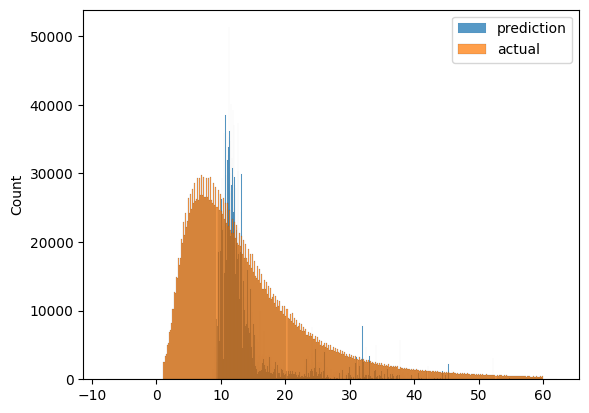

In [17]:
sns.histplot(y_pred, label='prediction')
sns.histplot(y_train, label='actual')

plt.legend()

### Q6. Evaluating the model

In [18]:
!pip install polars

import polars as pl

def read_data_polars(url):
    # 1. Read only the columns you need
    df = pl.read_parquet(
        url,
        columns=[
            "tpep_pickup_datetime",
            "tpep_dropoff_datetime",
            "PULocationID",
            "DOLocationID",
        ]
    )

    # 2. Compute duration (minutes) via nanosecond timestamps, and cast locations
    df = df.with_columns([
        # (dropoff_ns - pickup_ns) / 1e9 → seconds, /60 → minutes
        (
            (pl.col("tpep_dropoff_datetime").cast(pl.Int64)
           - pl.col("tpep_pickup_datetime").cast(pl.Int64))
            / 1e9
            / 60
        ).alias("duration"),

        # cast location IDs to string
        pl.col("PULocationID").cast(pl.Utf8),
        pl.col("DOLocationID").cast(pl.Utf8),
    ])

    # 3. Filter out outliers
    df = df.filter((pl.col("duration") >= 1) & (pl.col("duration") <= 60))

    return df

In [19]:
# Run it in one cell
df_val_pl = read_data_polars(
    "https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2024-02.parquet"
)
print("Polars DF shape:", df_val_pl.shape)

Polars DF shape: (2938060, 5)


In [20]:
# Convert to pandas for your existing pipeline
df_val = df_val_pl.to_pandas()
print(df_val.head())

  tpep_pickup_datetime tpep_dropoff_datetime PULocationID DOLocationID  \
0  2024-02-01 00:04:45   2024-02-01 00:19:58           68          236   
1  2024-02-01 00:56:31   2024-02-01 01:10:53           48          243   
2  2024-02-01 00:07:50   2024-02-01 00:43:12          132          261   
3  2024-02-01 00:01:49   2024-02-01 00:10:47          161          163   
4  2024-02-01 00:37:35   2024-02-01 00:51:15          246           79   

    duration  
0  15.216667  
1  14.366667  
2  35.366667  
3   8.966667  
4  13.666667  


In [21]:
val_dicts = df_val[categorical].to_dict(orient="records")
X_val = dv.transform(val_dicts)
y_val = df_val["duration"].values
y_pred = lr.predict(X_val)
print(f"Val RMSE: {root_mean_squared_error(y_val, y_pred):.3f}")

Val RMSE: 8.123
